# Global Covid-19 Forecasting using Machine Learning

## Mục tiêu
Xây dựng mô hình dự báo số ca nhiễm Covid-19 hằng ngày cho **toàn bộ quốc gia**
dựa trên dữ liệu chuỗi thời gian.

## Mô hình sử dụng
- Linear Regression
- Random Forest Regressor
- XGBoost Regressor

## Đặc trưng đầu vào
- lag_1: số ca ngày hôm trước
- lag_7: số ca 7 ngày trước
- rolling_mean_7: trung bình 7 ngày gần nhất
- Rolling_Slope_7
- Rolling_Std_7
- Cluster

## Chỉ số đánh giá
- MAE
- RMSE
- MAPE

## 1. Import Libraries


In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2. Load Dataset

The dataset already includes clustering results (K-Means)
and rolling epidemiological indicators.

In [48]:
df = pd.read_csv("../data/processed/timeseries_with_clusters.csv")
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

df.sort_values(['Country', 'Date_reported'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate,Cluster
0,2020-01-04,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
1,2020-01-05,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
2,2020-01-06,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
3,2020-01-07,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
4,2020-01-08,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1


## 3. Feature Engineering

We construct features reflecting:
- **Temporal dependency** (lags)
- **Trend** (rolling mean & slope)
- **Volatility** (rolling std)
- **Structural similarity** (Cluster)


In [49]:
def add_features(group):
    group = group.copy()
    
    group['lag_1'] = group['New_cases_MA7'].shift(1)
    group['lag_7'] = group['New_cases_MA7'].shift(7)
    
    group['Rolling_Mean_7'] = group['New_cases_MA7'].rolling(7).mean()
    group['Rolling_Std_7'] = group['New_cases_MA7'].rolling(7).std()
    
    # Rolling slope (trend strength)
    group['Rolling_Slope_7'] = (
        group['New_cases_MA7']
        .rolling(7)
        .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=False)
    )
    
    return group

df = df.groupby('Country').apply(add_features)
df.dropna(inplace=True)
df.head()

C:\Users\antrn\AppData\Local\Temp\ipykernel_15488\511947547.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Country').apply(add_features)


Date_reported Country_code      Country WHO_region  New_cases  \
Country                                                                        
Afghanistan 7     2020-01-11           AF  Afghanistan        EMR        0.0   
            8     2020-01-12           AF  Afghanistan        EMR        0.0   
            9     2020-01-13           AF  Afghanistan        EMR        0.0   
            10    2020-01-14           AF  Afghanistan        EMR        0.0   
            11    2020-01-15           AF  Afghanistan        EMR        0.0   

                New_deaths  Cumulative_cases  Cumulative_deaths  \
Country                                                           
Afghanistan 7          0.0                 0                  0   
            8          0.0                 0                  0   
            9          0.0                 0                  0   
            10         0.0                 0                  0   
            11         0.0                 0                  0   

                New_cases_MA7  New_deaths_MA7  Growth_Rate  Cluster  lag_1  \
Country                                                                      
Afghanistan 7             0.0             0.0          0.0        1    0.0   
            8             0.0             0.0          0.0        1    0.0   
            9             0.0             0.0          0.0        1    0.0   
            10            0.0             0.0          0.0        1    0.0   
            11            0.0             0.0          0.0        1    0.0   

                lag_7  Rolling_Mean_7  Rolling_Std_7  Rolling_Slope_7  
Country                                                                
Afghanistan 7     0.0             0.0            0.0              0.0  
            8     0.0             0.0            0.0              0.0  
            9     0.0             0.0            0.0              0.0  
            10    0.0             0.0            0.0              0.0  
            11    0.0             0.0            0.0              0.0

In [50]:
df.to_csv('data_with_features.csv', index=False, encoding='utf-8-sig')

## 4. Define Training and Test Periods

- **Train**: all data until 2022-12-31  
- **Test**: first 7 & 14 days of 2023


In [5]:
FEATURES = [
    'lag_1', 'lag_7',
    'Rolling_Mean_7', 'Rolling_Slope_7',
    'Rolling_Std_7',
    'Cluster'
]

TARGET = 'New_cases_MA7'

train_df = df[df['Date_reported'] <= '2022-12-31']
test_df = df[
    (df['Date_reported'] >= '2023-01-01') &
    (df['Date_reported'] <= '2023-01-14')
]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

dates_test = test_df['Date_reported']


## 5. Model Initialization

We compare three models with increasing non-linearity:
1. Linear Regression (baseline)
2. Random Forest (non-linear ensemble)
3. XGBoost (boosted trees)


In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        objective='reg:squarederror',
        random_state=42
    )
}

predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)


## 6. Evaluation Metrics

We evaluate performance at:
- 7-day horizon
- 14-day horizon

Metrics:
- MAE
- RMSE
- MAPE (interpreted with caution)


In [7]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(
        np.abs((y_true - y_pred) / np.maximum(y_true, 1))
    ) * 100
    return mae, rmse, mape


In [8]:
results = []

for name, y_pred in predictions.items():
    for h in [7, 14]:
        mae, rmse, mape = calculate_metrics(
            y_test.iloc[:h],
            y_pred[:h]
        )
        results.append({
            "Model": name,
            "Horizon (days)": h,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

results_df = pd.DataFrame(results)
results_df


,Model,Horizon (days),MAE,RMSE,MAPE (%)
0,Linear Regression,7,4.851291,5.898840,14.681006
1,Linear Regression,14,4.047794,5.046655,13.286213
2,Random Forest,7,2.851561,3.826577,9.947453
3,Random Forest,14,3.060323,3.761240,11.251208
4,XGBoost,7,9.020515,10.687529,30.684617
5,XGBoost,14,9.406616,10.380889,34.182452


## 7. Visualization: Actual vs Predicted (Early 2023)


In [28]:
# Gắn prediction vào test_df
plot_df = test_df.copy()

plot_df["Pred_LR"] = predictions["Linear Regression"]
plot_df["Pred_RF"] = predictions["Random Forest"]
plot_df["Pred_XGB"] = predictions["XGBoost"]

# Aggregate theo ngày (GLOBAL)
agg = plot_df.groupby("Date_reported").agg({
    "New_cases_MA7": "sum",
    "Pred_LR": "sum",
    "Pred_RF": "sum",
    "Pred_XGB": "sum"
}).reset_index()


### HÌNH 1 — MAE comparison (7 & 14 ngày)

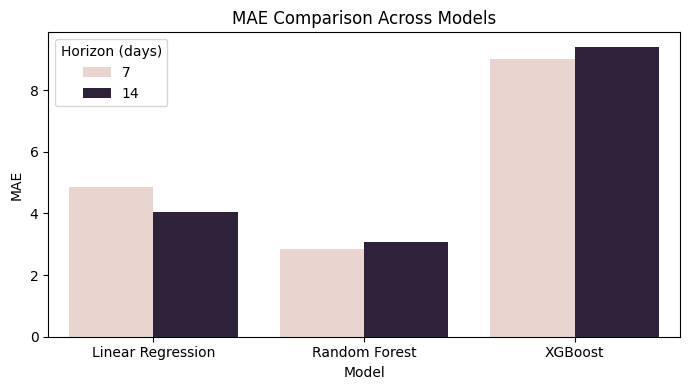

In [29]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="MAE", hue="Horizon (days)")
plt.title("MAE Comparison Across Models")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


### HÌNH 2 — RMSE comparison

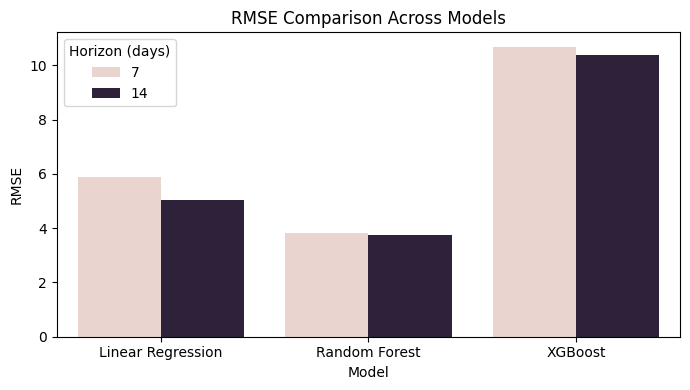

In [45]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="RMSE", hue="Horizon (days)")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


### HÌNH 3 — MAPE comparison

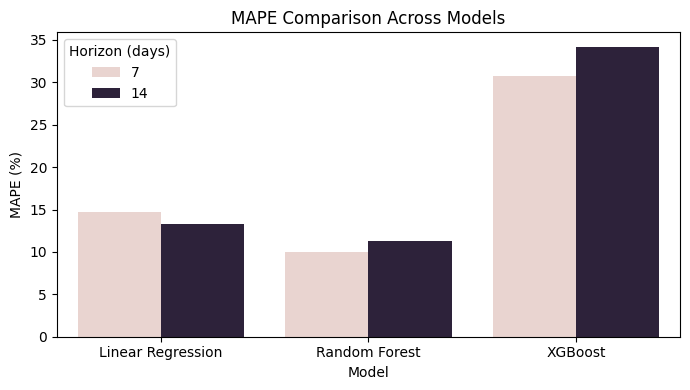

In [31]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="MAPE (%)", hue="Horizon (days)")
plt.title("MAPE Comparison Across Models")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


### HÌNH 4 — Heatmap MAE (Executive summary)

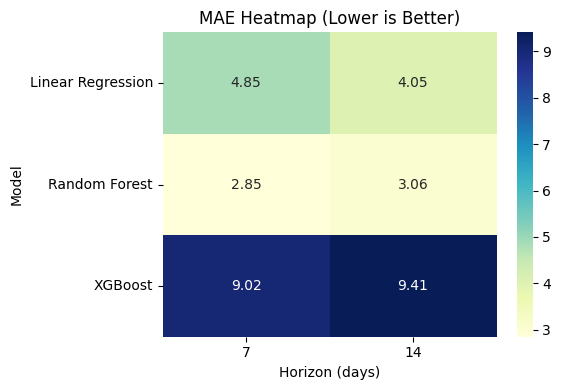

In [32]:
pivot = results_df.pivot(
    index="Model",
    columns="Horizon (days)",
    values="MAE"
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("MAE Heatmap (Lower is Better)")
plt.tight_layout()
plt.show()


### HÌNH 6 — So sánh 3 mô hình (GLOBAL)

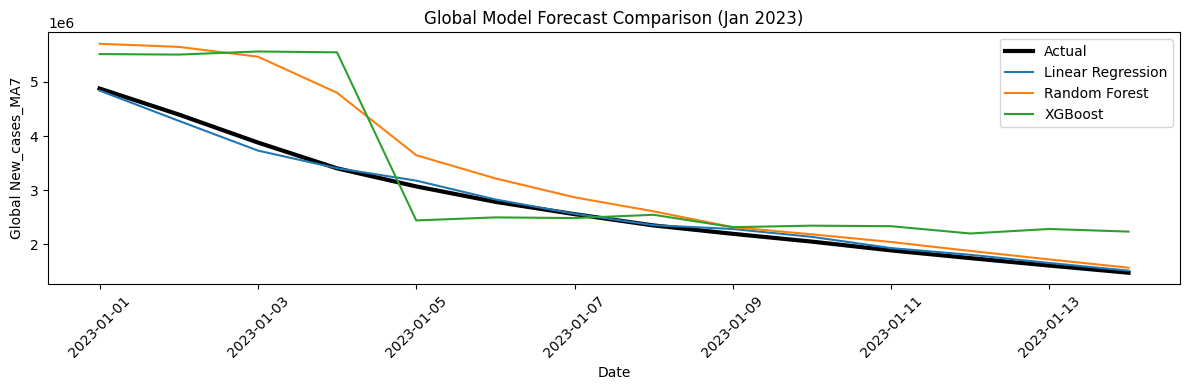

In [34]:
plt.figure(figsize=(12,4))
plt.plot(agg["Date_reported"], agg["New_cases_MA7"],
         label="Actual", linewidth=3, color="black")

plt.plot(agg["Date_reported"], agg["Pred_LR"], label="Linear Regression")
plt.plot(agg["Date_reported"], agg["Pred_RF"], label="Random Forest")
plt.plot(agg["Date_reported"], agg["Pred_XGB"], label="XGBoost")

plt.title("Global Model Forecast Comparison (Jan 2023)")
plt.xlabel("Date")
plt.ylabel("Global New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 5 — Actual vs Random Forest (GLOBAL)

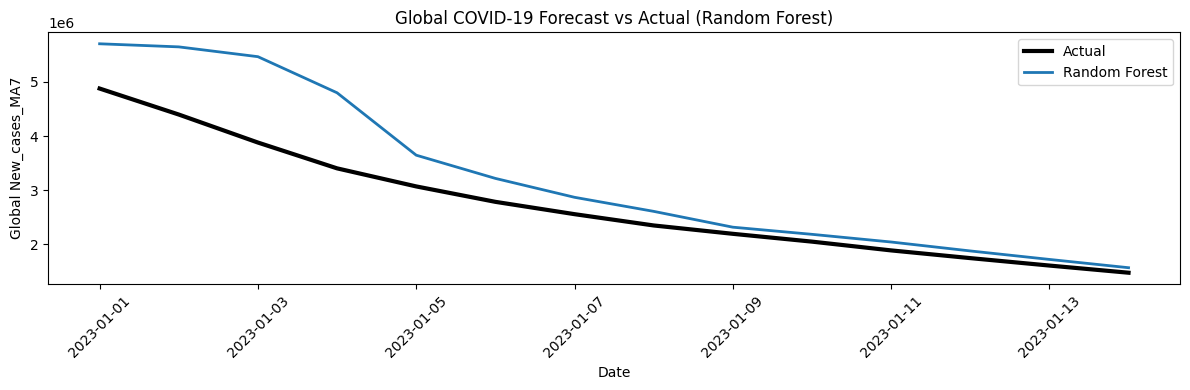

In [33]:
plt.figure(figsize=(12,4))
plt.plot(agg["Date_reported"], agg["New_cases_MA7"],
         label="Actual", linewidth=3, color="black")
plt.plot(agg["Date_reported"], agg["Pred_RF"],
         label="Random Forest", linewidth=2)

plt.title("Global COVID-19 Forecast vs Actual (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Global New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 7 — Residual theo thời gian (Random Forest)

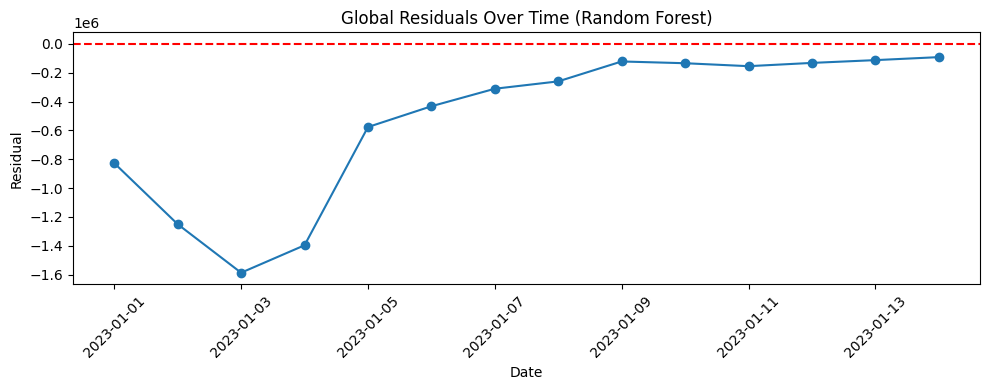

In [35]:
agg["Residual_RF"] = agg["New_cases_MA7"] - agg["Pred_RF"]

plt.figure(figsize=(10,4))
plt.plot(agg["Date_reported"], agg["Residual_RF"], marker='o')
plt.axhline(0, color='red', linestyle='--')

plt.title("Global Residuals Over Time (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 8 — Rolling MAE (Random Forest)

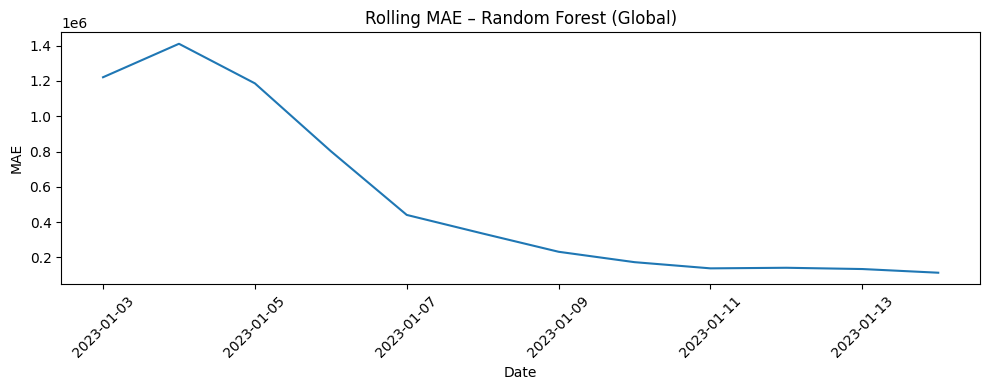

In [36]:
agg["Abs_Error_RF"] = np.abs(agg["New_cases_MA7"] - agg["Pred_RF"])
agg["Rolling_MAE_RF"] = agg["Abs_Error_RF"].rolling(3).mean()

plt.figure(figsize=(10,4))
plt.plot(agg["Date_reported"], agg["Rolling_MAE_RF"])

plt.title("Rolling MAE – Random Forest (Global)")
plt.xlabel("Date")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 9 — Residual distribution (3 models)

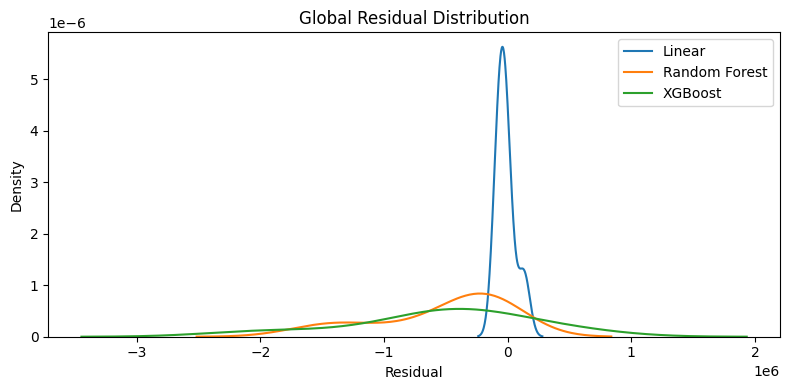

In [37]:
plt.figure(figsize=(8,4))

sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_LR"], label="Linear")
sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_RF"], label="Random Forest")
sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_XGB"], label="XGBoost")

plt.title("Global Residual Distribution")
plt.xlabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


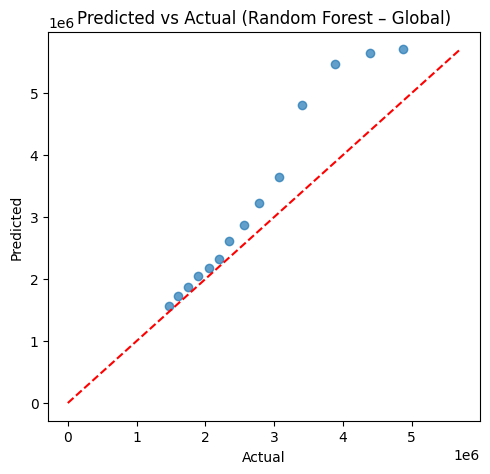

In [38]:
plt.figure(figsize=(5,5))
plt.scatter(agg["New_cases_MA7"], agg["Pred_RF"], alpha=0.7)

max_val = max(agg["New_cases_MA7"].max(), agg["Pred_RF"].max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Random Forest – Global)")
plt.tight_layout()
plt.show()


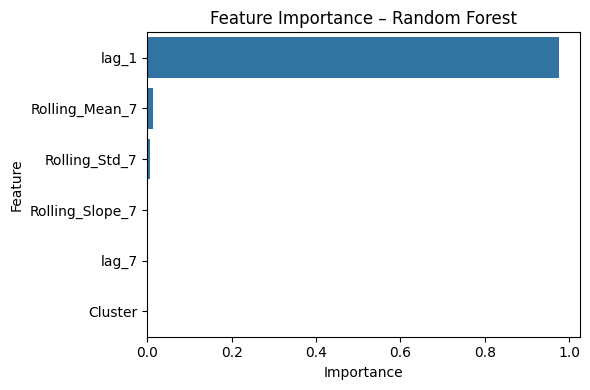

In [39]:
rf_model = models["Random Forest"]

fi_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi_df, x="Importance", y="Feature")
plt.title("Feature Importance – Random Forest")
plt.tight_layout()
plt.show()


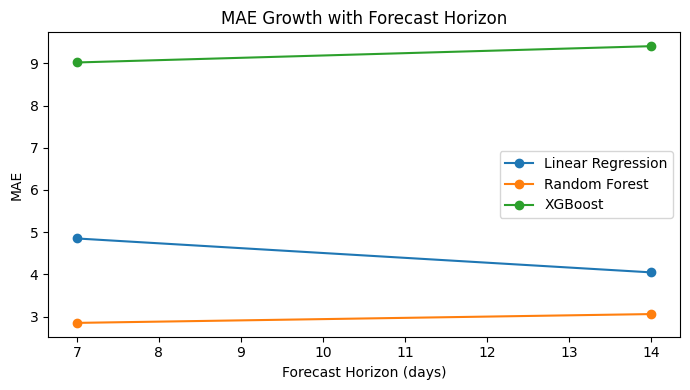

In [40]:
plt.figure(figsize=(7,4))

for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    plt.plot(subset["Horizon (days)"], subset["MAE"],
             marker='o', label=model)

plt.title("MAE Growth with Forecast Horizon")
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


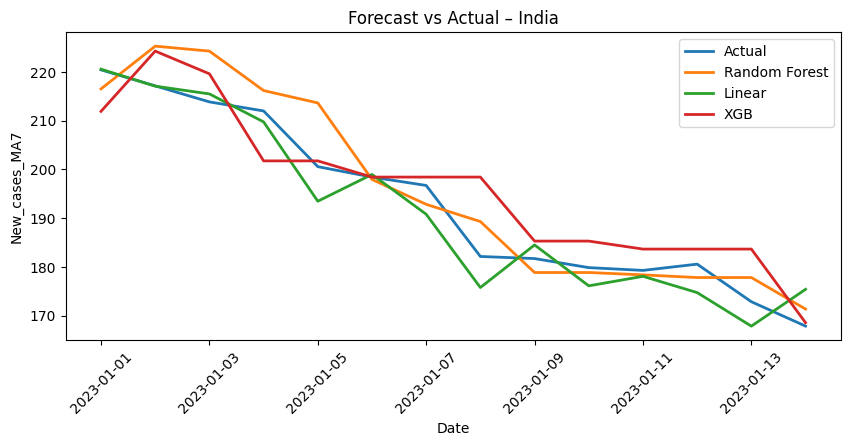

In [44]:
country = "India"

c_df = plot_df[plot_df["Country"] == country]

plt.figure(figsize=(10,4))
plt.plot(c_df["Date_reported"], c_df["New_cases_MA7"],
         label="Actual", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_RF"],
         label="Random Forest", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_LR"],
         label="Linear", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_XGB"],
         label="XGB", linewidth=2)

plt.title(f"Forecast vs Actual – {country}")
plt.xlabel("Date")
plt.ylabel("New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.show()
